# TDA intro - Alpha shapes and persistence

In this notebook I'll briefly outline a few basic concepts of TDA. A much more detailed discussion can be found in the book by Edelsbrunner & Harer (2010): [**Computational Topology: An introduction**](https://books.google.nl/books?id=LiljEAAAQBAJ&lpg=PP1&ots=JbpA1elQR6&dq=Computational%20Topology%3A%20An%20Introduction&lr&pg=PP1#v=onepage&q=Computational%20Topology:%20An%20Introduction&f=false). I will make use of alpha complexes, and do the computations with [Gudhi](http://gudhi.gforge.inria.fr/).

Alpha-complexes allow one to construct connected shapes from point clouds, and subsequently analyse their structure, form, and shape. They are closely linked to [Voronoi diagrams](https://en.wikipedia.org/wiki/Voronoi_diagram) and [Delaunay triangulation](https://en.wikipedia.org/wiki/Delaunay_triangulation). In a Voronoi diagram (see the figure below) space (or a plane, as in the figure) is partitioned into cells, where each cell is the region closest to the *seed* (or generator) of this region. These cells are called *Voronoi cells*.

<figure>
    <img src="./figures/Euclidean_Voronoi_diagram.svg" alt="Voronoi cells" width=400>
    <figcaption>Voronoi cells. <a href="https://commons.wikimedia.org/wiki/File:Euclidean_Voronoi_diagram.svg">Author: Balu Ertl</a></figcaption>
</figure>

## Delaunay triangulations

The Voronoi diagram of a set of points is the *dual* of the Delaunay triangulation of these points (meaning there is a one-to-one correspondence between the two). This can be seen in the figure below, with the Voronoi cells (red lines) of a set of black points, and the corresponding Delaunay triangulation of the black points. If two black points are connected via an edge of the (black) Delaunay triangulation, the corresponding Voronoi cells also touch along an edge. The Delaunay triangulation can also be referred to as a Delaunay complex.

<figure>
    <img src="./figures/Delaunay_Voronoi.svg" alt="Voronoi cells" width=400>
    <figcaption>Voronoi cells and Delaunay triangulation. <a href="https://commons.wikimedia.org/wiki/File:Delaunay_Voronoi.svg">Author: Nü Es</a></figcaption>
</figure>


## Alpha shape or alpha complex

An alpha shape is a *filtered* sub-complex of the Delaunay complex. To construct it we choose a value $\alpha$, construct a set of balls centred on the seed points, and then form connections according to the merging balls. This is illustrated in the figure below.

![Alpha complex (generated using this notebook)](./figures/alpha_complex1.png)

## TDA

Topological data analysis now allows us to analyse the structure and shape of these objects through tracking multi-dimensional holes. These multi-dimensional holes can be imagined as being surrounded by loop. I illustrate this in the following figure, where I'm showing a sphere and a torus. Both are hollow, and both contain a hole at their centre. This is essentielly a **two-dimensional hole**, as it can be contained by a two-dimensional manifold (in this case, the surfaces of the sphere and the torus).

The torus also contains **one-dimensional holes**: They are outlined as the two coloured bands on its surface: one through the central hole, and one around its equator. All of the above examples are "holes" in the sense that they can't be closed without breaking the (suface of) the objects - just by shifting them around (like rubber bands) we can not merge them into a point. If we tried putting two different rubber bands on the surface of the sphere, we would first notice that we can transform the first into the second, and then that, in fact, we can collapse it into a point. The surface of a sphere therefore does not contain any one-dimensional holes like the torus.

Finally, there are also the rather abstractly phrased **zero-dimensional holes**: Both objects consist of a single connected component, and the holes we can count would correspond to gaps in the structure. For example, the sphere and the torus are *not* connected, and therefore separated by such a gap. We can use this behaviour to look into clustering characteristics of structures.

The number of $k$-dimensional holes is referred to as the $k$th-Betti number $\beta_k$, and quantifies the topology of a structure. Via the alpha complexes illustrated above we can obtain a structure from a point cloud, and see how its topology changes when we change the parameter alpha. Changing alpha will change the number of holes in a structure. We will look at this more closely in the notebook.

![Sphere and Torus](./figures/sphere_torus.png)

# Imports

In [117]:
import gudhi
import numpy as np

from matplotlib import pyplot as plt
#from matplotlib.widgets import Slider, Button, RadioButtons

from matplotlib import (collections, tri)

from ipywidgets import interactive

# Functions

In [120]:
# class to store simplices of a specific dimension, sort them according to their
# filtration values (usually this is already done by Gudhi), and return sub-filtrations
class SimplexFiltration:
    """
    Class for keeping track of simplices and to generate sub-filtrations.
    """
    def __init__(self,filtration_list):
        n = []
        f = []
        for filtration in filtration_list:
            n.append(filtration[0])
            f.append(filtration[1])
        n = np.array(n)
        f = np.array(f)
        # (re-)sort
        ikx = np.argsort(f)
        f = f[ikx]
        n = n[ikx]
        self.n = n
        self.f = f
        
    def __call__(self,subfiltration):
        return self.n[:np.searchsorted(self.f,subfiltration, side='right')]

# function to plot an alpha shape
def plot_alpha(points, filtrations, alpha, show_balls=False, ax=None):
    
    # use this to plot into an axis
    if isinstance(ax,type(None)):
        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'aspect': 1})
    else:
        ax.set_aspect('equal')

    vertices, edges, faces = filtrations
    
    if edges(alpha) is not None and edges(alpha).size > 0:
        lines = collections.LineCollection(points[edges(alpha)], color='k')
        ax.add_collection(lines)

    # plot triangles
    if faces(alpha) is not None and faces(alpha).size > 0:
        colors = np.ones(len(faces(alpha)))
        ax.tripcolor(points[:,0],
                     points[:,1],
                     faces(alpha),
                     alpha=0.3, facecolors=colors)

    # show balls
    if show_balls:
        radius = np.ones(len(points)) * np.sqrt(alpha)
        angles = np.zeros(len(points))
        circles = collections.EllipseCollection(
            radius*2, radius*2, angles, offsets=points, units='xy',
            transOffset=ax.transData, alpha=1.0, color='#ffd0d0', zorder=0)
        ax.add_collection(circles, autolim=True)

    # plot vertices        
    ax.scatter(*points[vertices(alpha)].T, c='k', zorder=5)

# Generate pointcloud

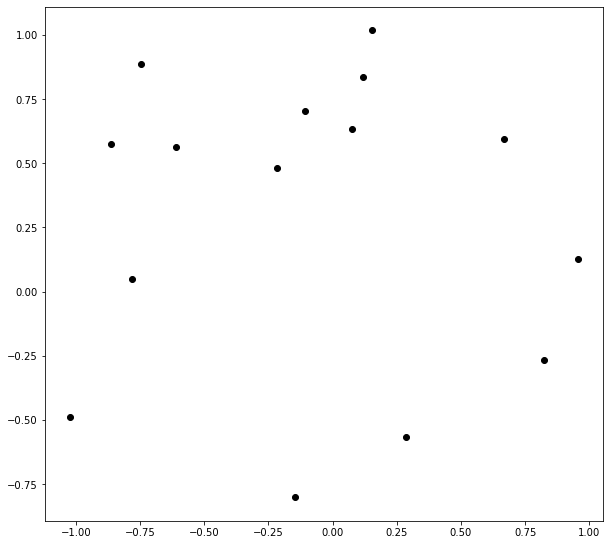

In [138]:
# create points randomly distributed around a circle with radius R
N = 400
R = 0.8
sigma = 0.15
theta = np.random.uniform(0, 2*np.pi, N)
radius = np.random.normal(R, sigma, (N, 1))
points = radius*np.c_[np.cos(theta), np.sin(theta)]

# visualise:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(*points.T,c='k')
ax.set_aspect('equal')

# Calculate persistence

Compute the alpha complex, the filtration, and persistence using Gudhi.

In [139]:
use_alpha = True

# create the alpha complex for the point cloud
alpha_complex = gudhi.AlphaComplex(points)

# create the simplex tree
simplex_tree = alpha_complex.create_simplex_tree()
simplex_tree.initialize_filtration()

# determine the points' position in the filtration
f = simplex_tree.get_filtration()

# calculate persistence pairs
p = simplex_tree.persistence()

# get the lists of simplices
f_vertices = [f for f in f if len(f[0]) == 1]
f_edges    = [f for f in f if len(f[0]) == 2]
f_faces    = [f for f in f if len(f[0]) == 3]

# these objects allow quick determination of sub-filtrations for plotting
vertices = SimplexFiltration(f_vertices)
edges    = SimplexFiltration(f_edges)
faces    = SimplexFiltration(f_faces)

## Alpha-shapes

We can now explore the alpha shapes we can obtain for our point cloud.

For different sub-filtrations (different $\alpha$) we get different connections, and they recover different aspects of the full structure. The top left panel ($\alpha$=0) only revocers the vertices, and no edges or faces. Accordingly, this is reflected in the Betti numbers, and $\beta_0$ = 400 (for the N=400 vertices we sample our our structure with), whereas $\beta_1$ = 0 (as no connections mean no 1-cycles).

The top-right panel already features significantly fewer connected components, and more loops. With an even higher $\alpha$ in the bottom-left panel more components merge, and loops disappear, until (bottom-right) only the big central loop remains.

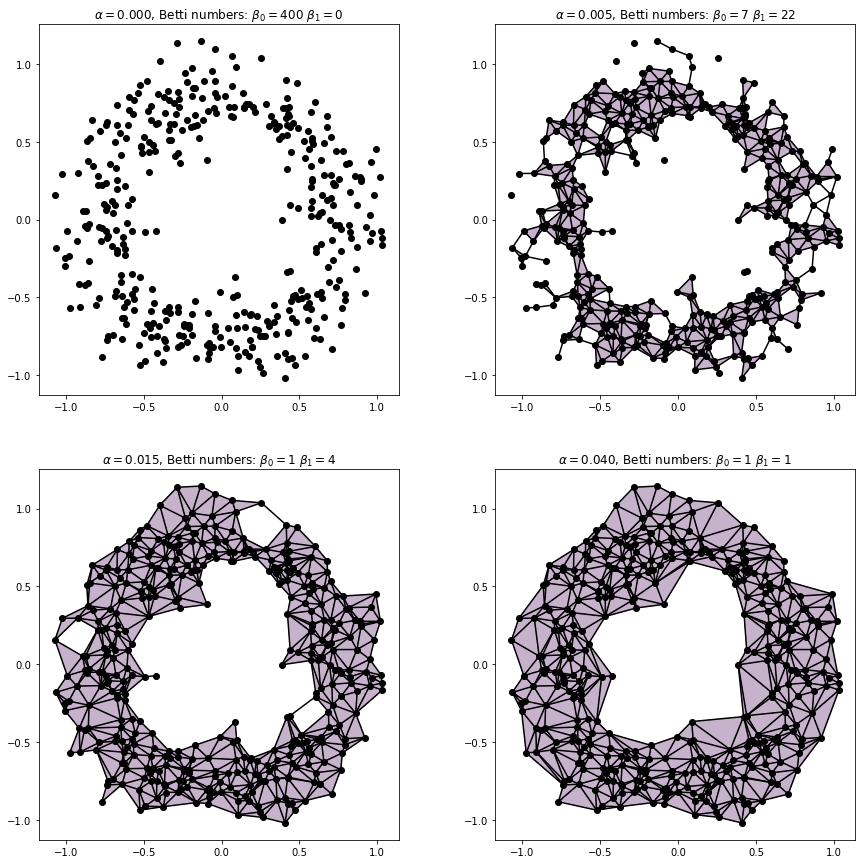

In [114]:
fig, ax = plt.subplots(2,2,figsize=(15,15))

for ax_id, alpha in enumerate([0.0,0.005,0.015,0.04]):
    plot_alpha(points, (vertices, edges, faces), alpha, show_balls=False,ax=ax.flat[ax_id])
    title_str = r'$\alpha=$%1.3f, Betti numbers: $\beta_0=$%i $\beta_1=$%i'%((alpha,)
                                                                             +tuple(simplex_tree.persistent_betti_numbers(alpha,alpha)))
    ax.flat[ax_id].set_title(title_str)

# Interactive plot

Using ipywidgets, we can also create an interactive plot to explore the point cloud. This animation is based on (with some adaptions, such as the class-based approach to get sub-filtrations) a [notebook on TDA by Johan Hiding](https://github.com/jhidding/topological-data-analysis).

In [115]:
interactive_plot = interactive(lambda alpha,show_balls: plot_alpha(points,
                                                                   (vertices, edges, faces),
                                                                   alpha**2,
                                                                   show_balls),
                               alpha=(filtration_min,filtration_max/2,0.01),
                               show_balls=False)
output = interactive_plot.children[-1]
output.layout.height = '600px'
interactive_plot

interactive(children=(FloatSlider(value=0.25, description='alpha', max=0.5, step=0.01), Checkbox(value=False, …